In [1]:
import pandas as pd
import numpy as np
import glob
import math

from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import gridspec
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
plt.style.use('default')
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot

import pingouin as pg
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import LSTM, Flatten


from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import RandomForestRegressor


2023-09-01 01:50:34.251260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Read the data files, where so far date has only been made consistent.

#### Merge them 
#### Identify Missing values and Impute them
#### Identify Outliers and summarize them
#### Exploratory analysis
#### Normalize Data



## ..

## 1. Merging data based on common dates

In [2]:
WaterLevel = pd.read_csv('/Users/asur18/Desktop/MSc_Project_Data/My_Appoach/Data/v1_WaterLevel.csv')
SoilMoisture = pd.read_csv('/Users/asur18/Desktop/MSc_Project_Data/My_Appoach/Data/v1_SoilMoisture.csv')
WeatherData = pd.read_csv('/Users/asur18/Desktop/MSc_Project_Data/My_Appoach/Data/v2_weatherData.csv')


# Convert the 'Date' column to datetime
def convert_to_datetime(df):
    try:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    except:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
    return df

WaterLevel = convert_to_datetime(WaterLevel)
SoilMoisture = convert_to_datetime(SoilMoisture)
WeatherData = convert_to_datetime(WeatherData)

# Write few lines about the count of data, data types

## ..

### Find the Common dates from three datsets

In [3]:
# Find the Unique dates between the three datasets
waterlevel_dates = set(WaterLevel['Date'].unique())
waterlevel_dates

soilmoisture_dates = set(SoilMoisture['Date'].unique())
soilmoisture_dates

weather_dates = set(WeatherData['Date'].unique())
weather_dates



# Find the common dates between the three datasets
common_dates = waterlevel_dates.intersection(soilmoisture_dates).intersection(weather_dates)
len(common_dates)

700

In [4]:
# Resample data for each dataset to obtain daily values (mean for each day)

# WaterLevel
Daily_WaterLevel = WaterLevel[WaterLevel['Date'].isin(common_dates)].groupby('Date').mean().reset_index()

# SoilMoisture
Daily_SoilMoisture = SoilMoisture[SoilMoisture['Date'].isin(common_dates)].groupby('Date').mean().reset_index()

# WeatherData
Daily_WeatherData = WeatherData[WeatherData['Date'].isin(common_dates)].groupby('Date').mean().reset_index()

# Daily_WaterLevel.head(), Daily_SoilMoisture.head(), Daily_WeatherData.head()


/var/folders/xf/bqcvwmvn191_cjd3_dtm3pjr0000gn/T/ipykernel_7535/4100812320.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Daily_WaterLevel = WaterLevel[WaterLevel['Date'].isin(common_dates)].groupby('Date').mean().reset_index()
/var/folders/xf/bqcvwmvn191_cjd3_dtm3pjr0000gn/T/ipykernel_7535/4100812320.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Daily_SoilMoisture = SoilMoisture[SoilMoisture['Date'].isin(common_dates)].groupby('Date').mean().reset_index()
/var/folders/xf/bqcvwmvn191_cjd3_dtm3pjr0000gn/T/ipykernel_7535/4100812320.py:10: FutureWarning: The default value of numeric_only in DataFram

### Finally, joining datasets based on the `common dates` and Sampling the data on weekly basis

In [5]:
# Merge the datasets based on common dates
merged_df = Daily_WaterLevel.merge(Daily_SoilMoisture, on='Date', how='left')
merged_df = merged_df.merge(Daily_WeatherData, on='Date', how='left')

In [6]:
merged_df.set_index('Date', inplace=True)
merged_df = merged_df.resample('W-THU').mean().reset_index()

### The columns in the dataframe are:

    - Date: The date of observation.
    - Water Column: The height of the water column in meters.
    - Water Temperature: The temperature of the water in degrees Celsius.
    - mm/h Max Precip Rate: The maximum precipitation rate in millimeters per hour.
    - m3/m3 Water Content: The volumetric water content of the soil in cubic meters per cubic meter.
    - degree_C Soil Temperature: The temperature of the soil in degrees Celsius.
    - mS/cm Saturation Extract EC: The saturation extract electrical conductivity of the soil in millisiemens per centimeter.
    - kPa Atmospheric Pressure: The atmospheric pressure in kilopascals.
    - degree_C Air Temperature: The air temperature in degrees Celsius.
    - W/m² Solar Radiation: The solar radiation in watts per square meter.

## ..



## 2. Identify Missing values and Impute them



In [7]:
merged_df= pd.read_csv('/Users/asur18/Desktop/MSc_Project_Data/My_Appoach/Data/my_final_merged_data.csv')
# Convert the 'Date' column to datetime
def convert_to_datetime(df):
    try:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    except:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
    return df

merged_df = convert_to_datetime(merged_df)


## Since our raw data had innumerous variables, we considered only those relevant to our study. 


    From here we only consider thse below meteorlogical factors:
    - 'Water Column', 'Water Temperature',
    - 'mm/h Max Precip Rate'
    - 'm3/m3 Water Content',
    - 'degree_C Soil Temperature'
    - 'mS/cm Saturation Extract EC'
    - 'kPa Atmospheric Pressure'
    - 'degree_C Air Temperature',
    - 'W/m² Solar Radiation'


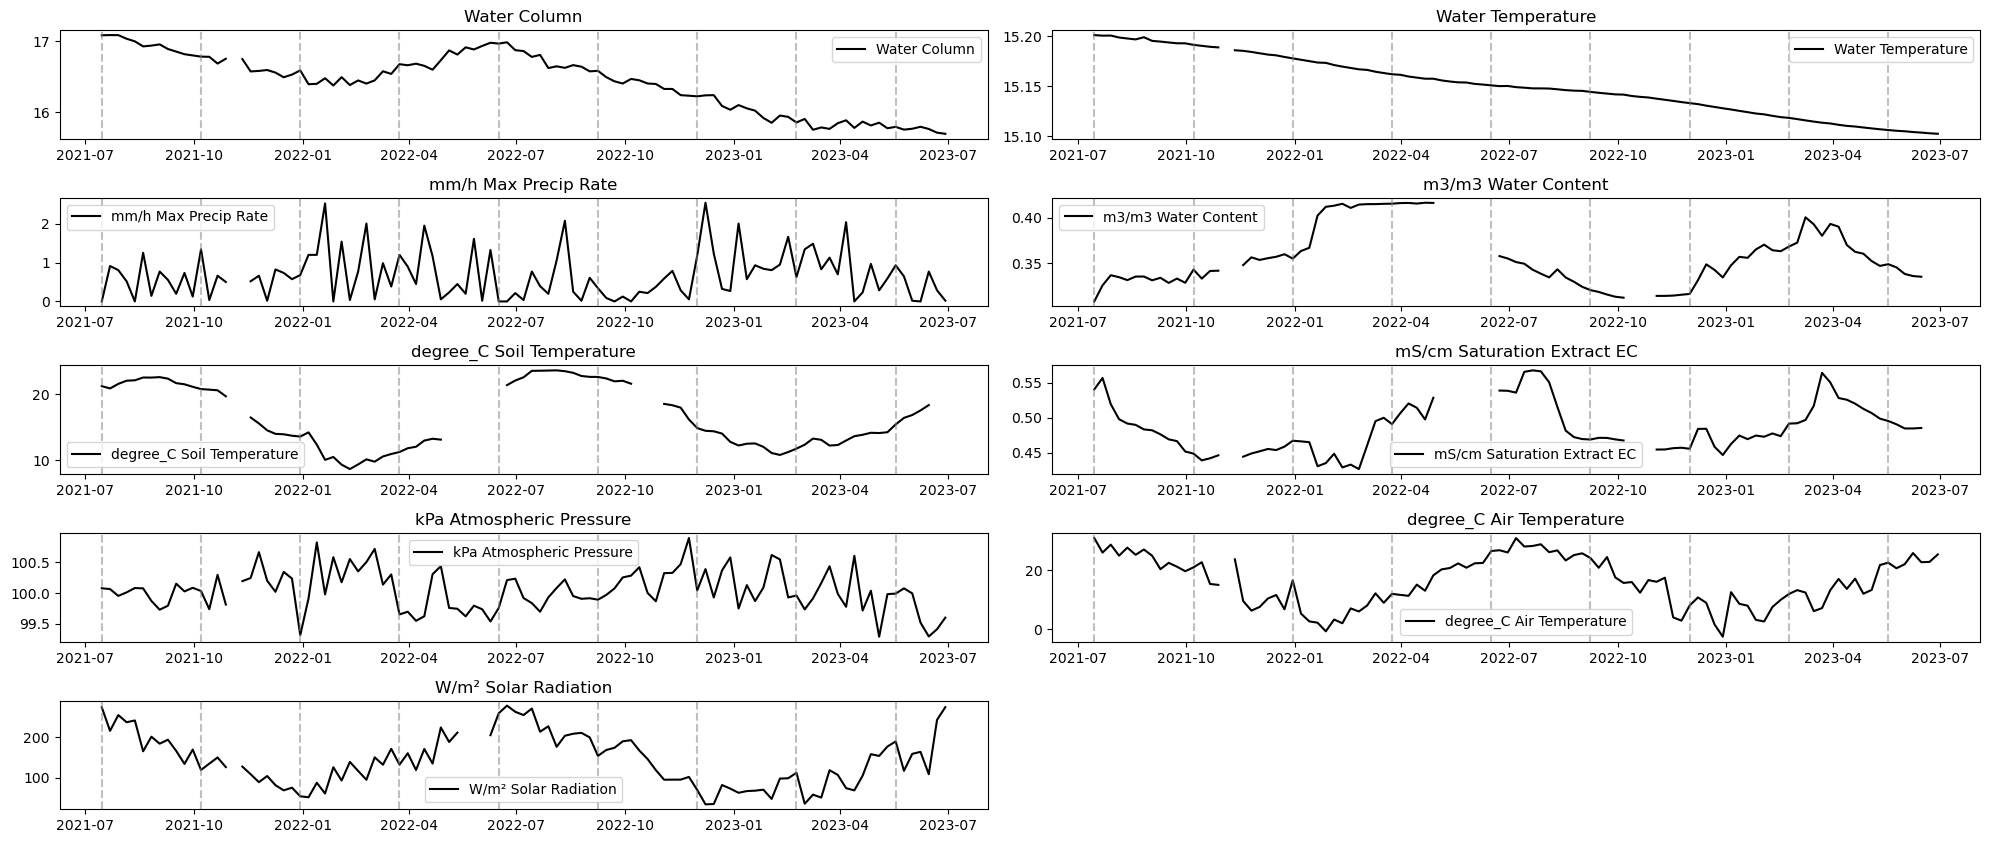

In [8]:
merged_df = merged_df[['Date','Water Column', 'Water Temperature',
       'mm/h Max Precip Rate', 'm3/m3 Water Content',
       'degree_C Soil Temperature', 'mS/cm Saturation Extract EC',
       'kPa Atmospheric Pressure', 'degree_C Air Temperature',
       'W/m² Solar Radiation']]

columns_to_check = ['Water Column', 'Water Temperature',
       'mm/h Max Precip Rate', 'm3/m3 Water Content',
       'degree_C Soil Temperature', 'mS/cm Saturation Extract EC',
       'kPa Atmospheric Pressure', 'degree_C Air Temperature',
       'W/m² Solar Radiation']

# Plotting the missing data for the specified columns
plt.figure(figsize=(20, 15))

for idx, column in enumerate(columns_to_check, 1):
    plt.subplot(9, 2, idx)
    plt.plot(merged_df['Date'], merged_df[column], label=column, linestyle='-', color = 'black')
    plt.legend(loc='best')
    plt.title(column)
    plt.tight_layout()
    
    # # Add vertical lines for each week
    current_date = merged_df['Date'].min()
    end_date = merged_df['Date'].max()
    while current_date <= end_date:
        plt.axvline(current_date, color='grey', linestyle='--', alpha=0.5)
        current_date += pd.DateOffset(weeks=12)
    

plt.show()


## Missing Value Summary/column 


    - Water Column: 1 missing value (0.97%)
    - Water Temperature: 1 missing value (0.97%)
    - mm/h Max Precip Rate: 2 missing values (1.94%)
    - m3/m3 Water Content: 13 missing values (12.62%)
    - degree_C Soil Temperature: 13 missing values (12.62%)
    - mS/cm Saturation Extract EC: 13 missing values (12.62%)
    - kPa Atmospheric Pressure: 1 missing value (0.97%)
    - degree_C Air Temperature: 1 missing value (0.97%)
    - W/m² Solar Radiation: 4 missing values (3.88%)
 

In [9]:
missing_values_rows = merged_df[merged_df.isnull().any(axis=1)]
# Creating a summary of missing values for each date
missing_summary = missing_values_rows.apply(lambda x: x.isnull().sum(), axis=1)
missing_days_summary = pd.DataFrame({
    'Date': missing_values_rows['Date'],
    'Number of Missing Values': missing_summary,
    'Columns with Missing Values': missing_values_rows.apply(lambda x: ", ".join(x.index[x.isnull()]), axis=1)
}).reset_index(drop=True)

missing_days_summary


,Date,Number of Missing Values,Columns with Missing Values
0,2021-11-04,9,"Water Column, Water Temperature, mm/h Max Prec..."
1,2021-11-11,4,"mm/h Max Precip Rate, m3/m3 Water Content, deg..."
2,2022-05-05,3,"m3/m3 Water Content, degree_C Soil Temperature..."
3,2022-05-12,3,"m3/m3 Water Content, degree_C Soil Temperature..."
4,2022-05-19,4,"m3/m3 Water Content, degree_C Soil Temperature..."
5,2022-05-26,4,"m3/m3 Water Content, degree_C Soil Temperature..."
6,2022-06-02,4,"m3/m3 Water Content, degree_C Soil Temperature..."
7,2022-06-09,3,"m3/m3 Water Content, degree_C Soil Temperature..."
8,2022-06-16,3,"m3/m3 Water Content, degree_C Soil Temperature..."
9,2022-10-13,3,"m3/m3 Water Content, degree_C Soil Temperature..."


### Findings

    (i) From the summary, it's evident that the columns related to `SoilMoisture` (like m3/m3 Water Content, mS/cm Saturation Extract EC and degree_C Soil Temperature) frequently have missing values,  pointing to issues with the equipment or data collection process.

    (ii) From May `2022 to June 2022` there is a continuos missing value in `Soil Moisture` weekly data, which shows for a long period there was some incidents which led to a large amount of data loss (as our data was daily data previously)
 
    (iii) There's also one day `(2021-11-04)` where almost all columns have missing values, which might suggest a system-wide issue or failure on that particular day.

In [10]:
def handle_missing_values_v2(df, method):
    """
    Handle missing values in the DataFrame.
    
    Parameters:
    - df (DataFrame): Input DataFrame with missing values.
    - method (str): Method to handle missing values. Options: 'custom', 'linear', 'multiple'.
    
    Returns:
    - DataFrame: DataFrame after handling missing values.
    """
    df_copy = df.copy()  # Create a copy of the input DataFrame to avoid modifying it in-place
    
    if method == 'custom':
        # Custom method as provided
        for column in df_copy.columns:
            for i in range(len(df_copy)):
                if pd.isnull(df_copy[column].iloc[i]):
                    if i > 0 and i < len(df_copy) - 1 and not pd.isnull(df_copy[column].iloc[i-1]) and not pd.isnull(df_copy[column].iloc[i+1]):
                        df_copy[column].iloc[i] = (df_copy[column].iloc[i-1] + df_copy[column].iloc[i+1]) / 2
                    else:
                        df_copy[column].interpolate(method='linear', inplace=True)
        
#     elif method == 'multiple':
#         # Multiple imputation
#         imputer = IterativeImputer(max_iter=10, random_state=0)
#         imputed_df = imputer.fit_transform(df_copy.select_dtypes(include=[np.number]))  # Select only numeric columns
#         df_copy[df_copy.select_dtypes(include=[np.number]).columns] = imputed_df
        
    else:
        raise ValueError("Method should be one of 'custom', 'linear', or 'multiple'.")
    
    return df_copy

# Assuming that 'merged_df' is the DataFrame with missing values
handled_df = merged_df.copy()  # Create a copy of the merged_df to avoid modifying it in-place

# Iterate over each column in the DataFrame
for column in merged_df.columns:
    # Count the missing values in the column
    missing_count = merged_df[column].isnull().sum()
    
    # If there's only one missing value, use the custom method
    if missing_count == 1:
        handled_df = handle_missing_values_v2(handled_df, method='custom')
    
#     # If there are multiple missing values, use the multiple imputation method
#     elif missing_count > 1:
#         handled_df = handle_missing_values_v2(handled_df, method='multiple')

# Check the updated DataFrame with missing values handled
handled_df.isnull().sum()


/var/folders/xf/bqcvwmvn191_cjd3_dtm3pjr0000gn/T/ipykernel_7535/2010143407.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy[column].iloc[i] = (df_copy[column].iloc[i-1] + df_copy[column].iloc[i+1]) / 2


Date                           0
Water Column                   0
Water Temperature              0
mm/h Max Precip Rate           0
m3/m3 Water Content            0
degree_C Soil Temperature      0
mS/cm Saturation Extract EC    0
kPa Atmospheric Pressure       0
degree_C Air Temperature       0
W/m² Solar Radiation           0
dtype: int64

## Plotted those column with significant amount of missing data

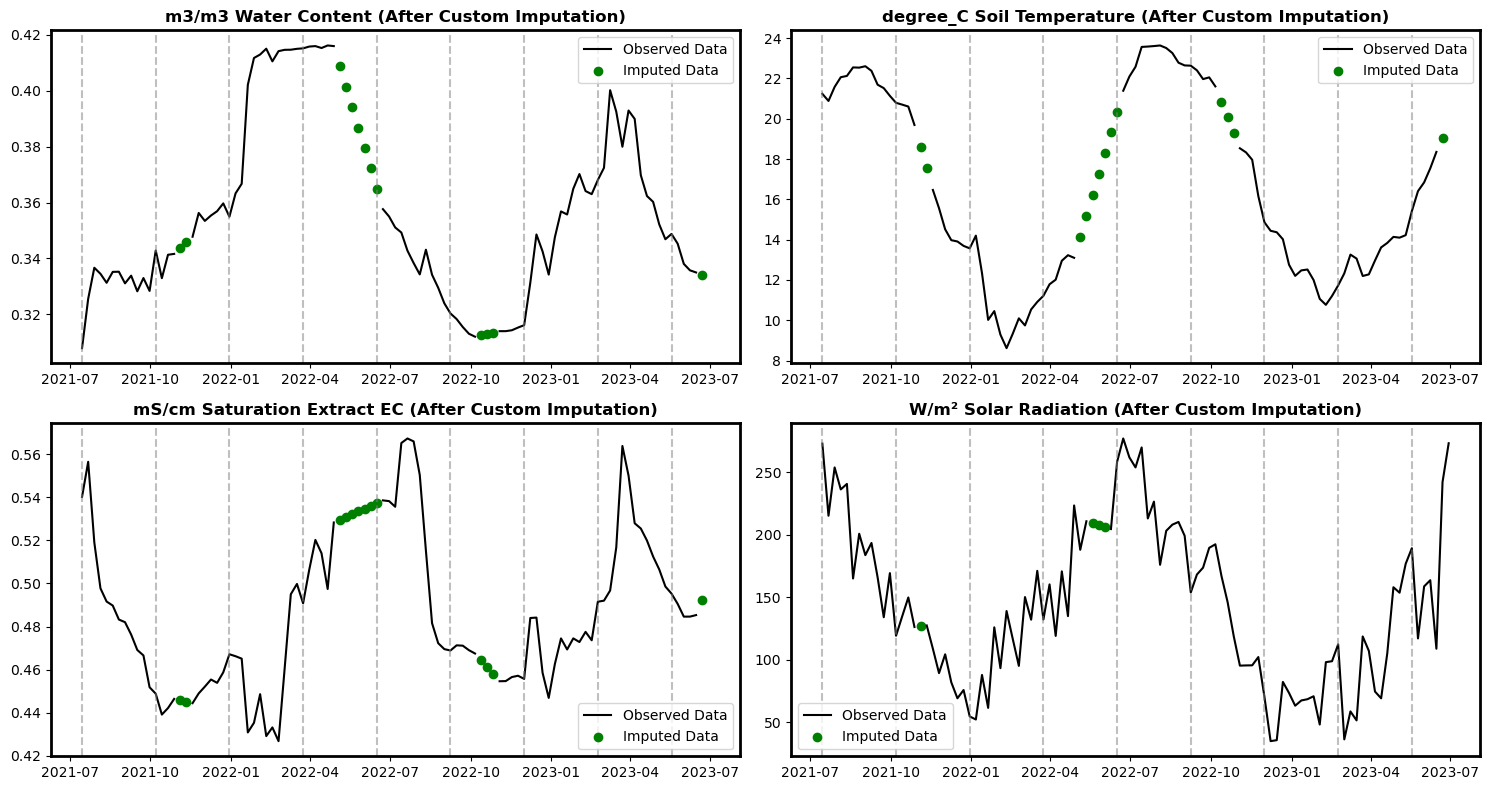

In [11]:
# Plotting the original data and imputed values for comparison
plt.figure(figsize=(15, 8))

columns_to_plot_mis = ['m3/m3 Water Content',
       'degree_C Soil Temperature', 'mS/cm Saturation Extract EC','W/m² Solar Radiation']

for idx, column in enumerate(columns_to_plot_mis, 1):
    ax = plt.subplot(2, 2, idx)  # Capture the axis object here
    
    # Plotting original data
    plt.plot(merged_df['Date'], merged_df[column], label='Observed Data', linestyle='-', color='black')
    
    # Highlighting the imputed values
    missing_values_index = merged_df[column].isna()
    plt.scatter(handled_df['Date'][missing_values_index], 
                handled_df[column][missing_values_index], 
                color='green', label='Imputed Data')
    
    plt.legend(loc='best')
    plt.title(column + ' (After Custom Imputation)',fontweight='bold')
    plt.tight_layout()
    
    # Add vertical lines for each week
    current_date = merged_df['Date'].min()
    end_date = merged_df['Date'].max()
    while current_date <= end_date:
        plt.axvline(current_date, color='grey', linestyle='--', alpha=0.5)
        current_date += pd.DateOffset(weeks=12)
        
    # Add bold border around each plot
    for spine in ax.spines.values():  # Using the ax variable here
        spine.set_linewidth(2)

plt.tight_layout()
plt.show()


### Summary of how missing values was imputed ...

We employed two different techniques to impute missing values in the dataset:

1. **Custom Mean Interpolation:** For columns with a single missing value, we used a custom mean interpolation method. In this approach, if there is a missing value at time $ t $, denoted as $ x_{NA} $, we imputed it using the formula:

$$ x_{NA} = \frac{x_{t-1} + x_{t+1}}{2} $$

where $ x_{t-1} $ and $ x_{t+1} $ represent the complete data at the previous time and the time after the missing data, respectively.

2. **Linear Interpolation:** In case where there is multiple consicutive missing values, we have use `linear interpolation` to impute them.



### Time Complexity for Missing value

Let's denote the number of columns in the DataFrame as $n$ and the number of rows in the DataFrame as $n$.

1. **Custom Method**:
   - The outer loop iterates through each column, which takes $ O(n) $.
   - The inner loop iterates through each row, which takes $O(n)$.
   - The operations inside the inner loop (checking for missing values, accessing previous and next elements, and performing arithmetic operations) take constant time $O(1)$.
   - **Therefore, the time complexity for the custom method is $ O(n \cdot n) = O(n^2) $.**
   


3. **Other Operations**:
   - Copying the DataFrame, selecting specific columns, and assigning values take time proportional to the size of the DataFrame, which is $ O(n \cdot n) = O(n^2)$.

Combining all the steps, the overall time complexity of the `handle_missing_values_v2` function is:

$$
O(n^2)  + O(n^2) = O(n^2)
$$

    where n is the number of columns and the number of rows in the DataFrame.



### ...

##### NOTE: The time complexity here is $ O(n^2) $ which is computationally expensive so this method is not recommended, but since the focus of this study to enhance the predictive performance of our Neural models to simulate near real-time water level, we have adopted to this technique. While working with larger datasets more effiecient and robust techniques should be use to impute the missing values.



## ..



## 4. Exploratory Analysis

    - At this point, we created separate datafiles for each of our models in order to facilitate a smoot experiement. As neural models might take longer time to run thus, this approach was taken to run parrallely in different Jupyter files.


In [12]:
def convert_to_datetime(df):
    try:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    except:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
    return df

arima_data = pd.read_csv('/Users/asur18/Desktop/MSc_Project_Data/My_Appoach/Data/arima_data.csv')

arima_data = convert_to_datetime(arima_data)

In [13]:
arima_data = arima_data[['Date','Water Column', 'Water Temperature',
       'mm/h Max Precip Rate', 'm3/m3 Water Content',
       'degree_C Soil Temperature', 'mS/cm Saturation Extract EC',
       'kPa Atmospheric Pressure', 'degree_C Air Temperature',
       'W/m² Solar Radiation']]

arima_data.set_index('Date',inplace=True)
monthly_df = arima_data.resample('M').mean()
arima_data.reset_index(inplace=True)


#Describe the dataset
monthly_df.describe()

,Water Column,Water Temperature,mm/h Max Precip Rate,m3/m3 Water Content,degree_C Soil Temperature,mS/cm Saturation Extract EC,kPa Atmospheric Pressure,degree_C Air Temperature,W/m² Solar Radiation
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,16.443157,15.151929,0.671593,0.356307,16.746429,0.487609,100.047867,16.331077,146.194686
std,0.413400,0.030166,0.313627,0.031913,4.495101,0.034662,0.211204,8.003835,59.190649
min,15.744211,15.103700,0.209821,0.312763,9.333557,0.434368,99.564161,2.347693,59.103046
25%,16.127063,15.129198,0.463348,0.334443,12.775352,0.461313,99.956464,10.395254,95.031105
50%,16.523022,15.149748,0.616071,0.348337,16.368493,0.484109,100.025095,15.130859,152.521628
75%,16.752159,15.176184,0.928677,0.374440,20.647950,0.516636,100.169262,22.941315,191.798897
max,17.082561,15.200851,1.227679,0.415885,23.330952,0.558577,100.499116,29.107217,247.359623


    Our study aimed to understand the impact of various meteorological factors on water levels. We started by loading the dataset and conducting preliminary statistics to describe the central tendency, dispersion, and range of values in each variable.

    `Water Column`: The water column shows a mean value of 16.44 and a standard deviation of 0.41. The minimum and maximum values are 15.74 and 17.08, respectively.
---

    `Water Temperature`: This variable presents an average of 15.15, with a standard deviation of 0.03. It ranges from 15.10 to 15.20.
---

    `Max Precip Rate`: The mean value is 0.67, and the standard deviation is 0.31. The values range from 0.21 to 1.23.
---

    `Water Content`: The mean value is 0.36, and the standard deviation is 0.03. It varies from 0.31 to 0.42.
---

    `Soil Temperature`: This factor has a mean of 16.75 and a standard deviation of 4.50. It ranges from 9.33 to 23.33.
---

    `Saturation Extract EC`: The mean value is 0.49, with a standard deviation of 0.03. The values span from 0.43 to 0.56.
---

    `Atmospheric Pressure`: The average value is 100.05, with a standard deviation of 0.21. It ranges from 99.56 to 100.50.
---

    `Air Temperature`: This variable presents a mean of 16.33 and a standard deviation of 8.00. It spans from 2.35 to 29.11.
---

    `Solar Radiation`: The mean value is 146.19, with a standard deviation of 59.19. The range is from 59.10 to 247.36.

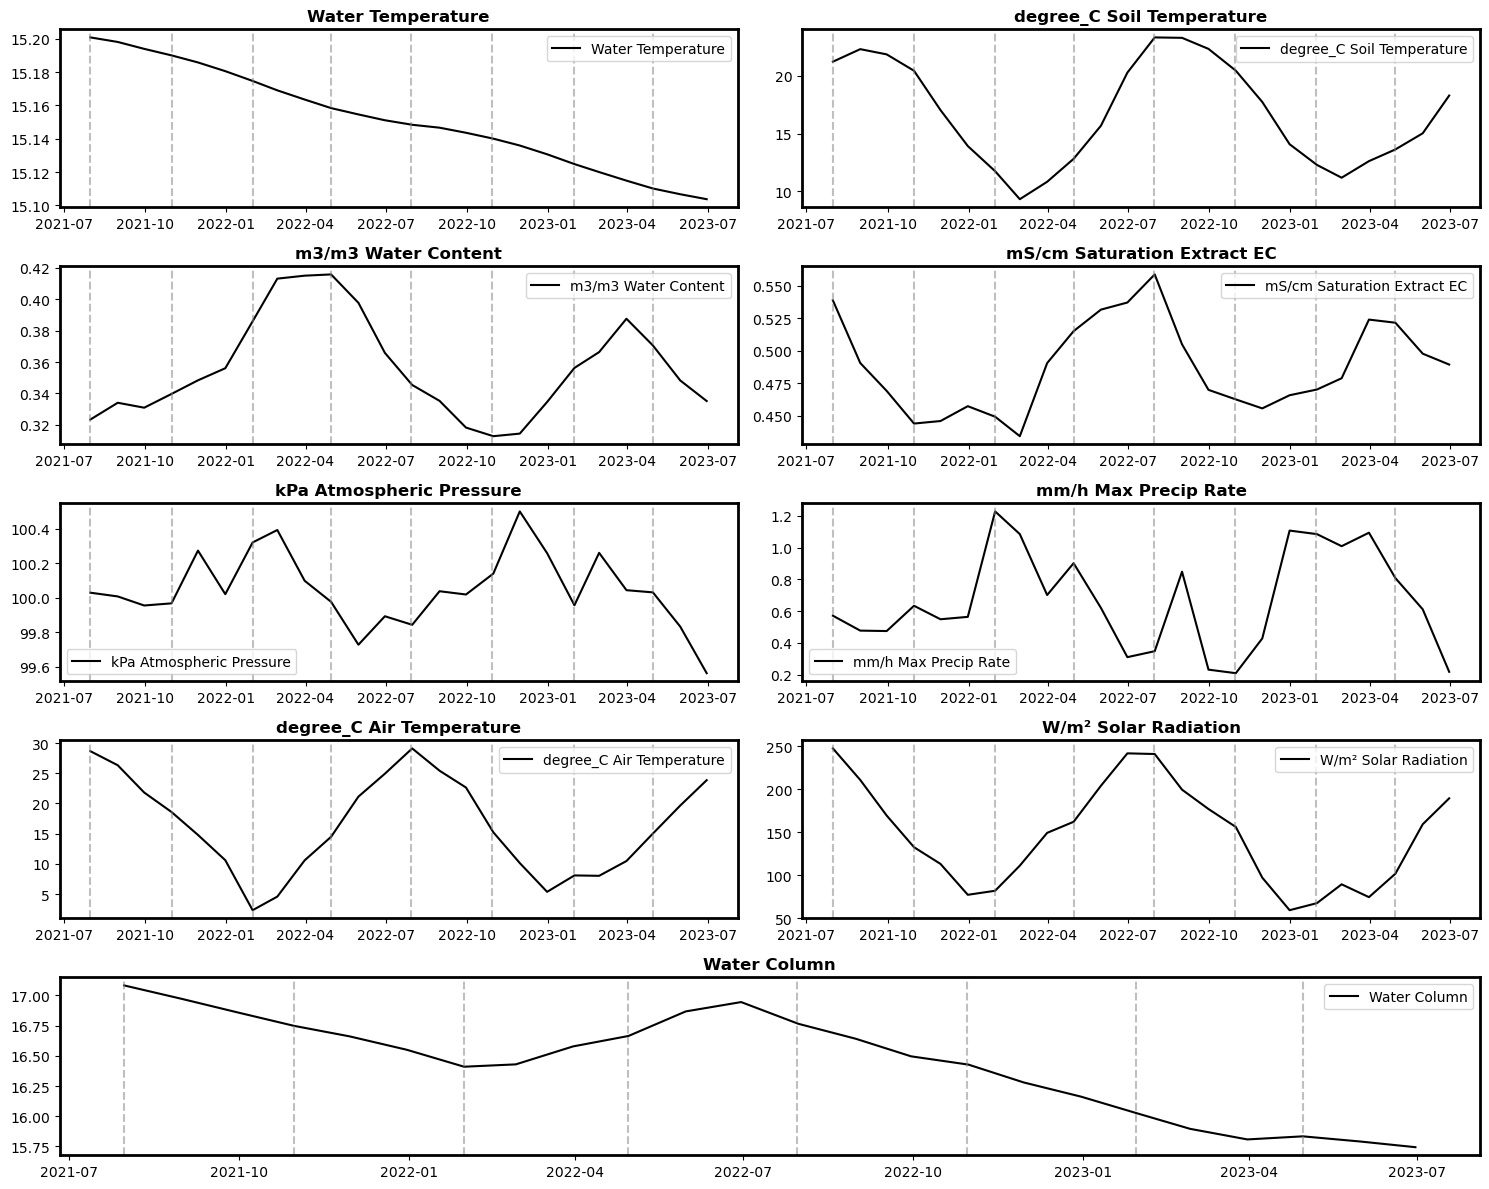

In [14]:
import pandas as pd
import matplotlib.pyplot as plt


# Define the columns to check
columns_to_check = ['Water Temperature', 'degree_C Soil Temperature', 
                    'm3/m3 Water Content',
                    'mS/cm Saturation Extract EC', 'kPa Atmospheric Pressure', 'mm/h Max Precip Rate',
                    'degree_C Air Temperature', 'W/m² Solar Radiation', 
                    'Water Column']  # 'Water Column' moved to the end

# Plot with bold borders
plt.figure(figsize=(15, 12))

for idx, column in enumerate(columns_to_check, 1):
    # For 'Water Column', make it span the entire row
    if column == 'Water Column':
        ax = plt.subplot(5, 2, (idx, idx + 1))
    else:
        ax = plt.subplot(5, 2, idx)
    
    plt.plot(monthly_df.index, monthly_df[column], label=column, linestyle='-', color = 'black')
    plt.legend(loc='best')
    plt.title(column, fontweight='bold')
    plt.tight_layout()
    
    # Add vertical lines for each week
    current_date = monthly_df.index.min()
    end_date = monthly_df.index.max()
    while current_date <= end_date:
        plt.axvline(current_date, color='grey', linestyle='--', alpha=0.5)
        current_date += pd.DateOffset(months=3)
        
    # Add bold border around each plot
    for spine in ax.spines.values():
        spine.set_linewidth(2)
plt.savefig("Monthly_data.png", dpi=300)
plt.show()



## ...Next we will zoom in the columns
---

    - Water column
    - Water Teperature
    - Air Temperature
    - Solar Radiation
    - Soil Temperature
    - Water Content

**We will plot the monthly distrbution of our time-series to see how visually these factors may affect water column.**

In [17]:
arima_data.set_index('Date', inplace= True)

## Analysis of Meteorological Factors on Water Levels

`In our study, we analyzed the relationships between different meteorological variables and the water column. Below are our findings:`

    - Water Column: The water column, with a mean value of 16.44 and standard deviation of 0.41, exhibits a slight seasonal variation coupled with a downward trend. We observe a peak around July, a low point in September 2022, followed by a consistent decrease until July 2023.

    - Water Temperature: With an average of 15.15 and standard deviation of 0.03, the water temperature shows a persistent downward trend from July 2021 to July 2023, more pronounced than the variation in the water column.

    - Max Precip Rate: This metric (mean: 0.67, standard deviation: 0.31) shows variability with peaks in February 2022, late December to January, and April 2023, but lacks a distinct seasonal pattern.

    - Water Content: With a mean of 0.36 and standard deviation of 0.03, this metric displays a seasonal pattern, peaking in March 2022 and falling in October-November 2022, with a subsequent rise and fall in early 2023.

    - Soil Temperature: The soil temperature (mean: 16.75, standard deviation: 4.50) shows a clear seasonal pattern, peaking around July, reaching its lowest point in March, and following a similar pattern the next year.

    - Saturation Extract EC: With an average of 0.49 and standard deviation of 0.03, this metric displays a slight seasonal variation, peaking in August and reaching a low point in March.

    - Atmospheric Pressure: The atmospheric pressure (mean: 100.05, standard deviation: 0.21) does not exhibit a clear seasonal pattern, but tends to peak in the winter months.

    Air Temperature: With a mean value of 16.33 and standard deviation of 8.00, air temperature shows a seasonal trend, peaking around July and reaching a low point in January.

    - Solar Radiation: With an average of 146.19 and standard deviation of 59.19, solar radiation also displays a seasonal pattern, peaking in June-July and dropping to its lowest in December.
---

`In conclusion, the fluctuations in the water column are influenced by a combination of factors such as water temperature, precipitation rate, water content, soil temperature, saturation extract EC, atmospheric pressure, air temperature, and solar radiation`. 

    The water column's behavior shows alignment with some of these factors, particularly water temperature, water content, and soil temperature, suggesting their significant contribution to water level variations. The descriptive statistics provide a quantitative foundation for these observed trends, supporting our analysis.

## Summary

    - water level & water temperature
    
    - water level & air temperature
    
    - water level & water content
    
    - water content & Solar radiation
    
    
    - `Monthly Distribution of Water Level`: This plot shows the distribution of water levels across different months. The water level appears to be higher in the middle months of the year (around May to September), and lower in the early and late months of the year.

    - `Monthly Distribution of Water Temperature`: This plot shows the distribution of water temperature across different months. There is an increase in temperature from January to July, with the temperature peaking around July-August. Then it starts to decrease, reaching its lowest point in December.

    - `Monthly Distribution of degree_C Air Temperature`: This plot shows the distribution of air temperature across different months. It follows a similar pattern to water temperature, peaking in the middle of the year and declining towards the beginning and end of the year.

    - `Monthly Distribution of W/m² Solar Radiation`: This plot shows the distribution of solar radiation across different months. The level of solar radiation increases from January to May, with a peak in the middle months (May-August). It then declines towards the end of the year.

    - `Monthly Distribution of degree_C Soil Temperature`: This plot shows the distribution of soil temperature across different months. It follows a similar pattern to air and water temperature, with a peak in the middle of the year and a decline towards the beginning and end of the year.

    - `Monthly Distribution of m3/m3 Water Content`: This plot shows the distribution of water content across different months. The water content seems to be higher in the early months of the year, decreases around April-May, and then increases again towards the end of the year.

`Each box in the boxplot represents the interquartile range (IQR) of the data, with the line inside the box representing the median. The whiskers extend to the most extreme data points within 1.5 times the IQR. Points outside of the whiskers are considered outliers.`

## Since we are concerned about predicting the fluctuations of water-level, we will be zooming into the 'Water Coulmn' to understand the nature of our data..


    - Check if our time series is `Stationary`
    - Check if the time series is `White Noise`
    - Decompose `Water Column` to find any `Trend`, `Seasonality` 

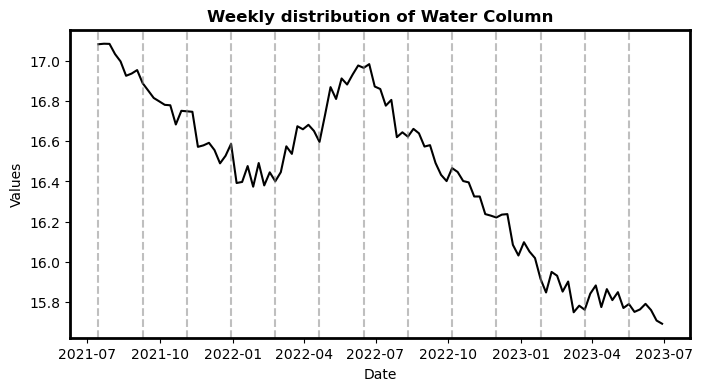

In [19]:
# Ensure the 'Date' column is set as the index and is in datetime format

# Plot the data
plt.style.use('default')
plt.figure(figsize=(8, 4))
plt.plot(arima_data['Water Column'], color = 'black')

# # Add vertical lines for each week
current_date = arima_data.index.min()
end_date = arima_data.index.max()
while current_date <= end_date:
    plt.axvline(current_date, color='grey', linestyle='--', alpha=0.5)
    current_date += pd.DateOffset(weeks=8)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Weekly distribution of Water Column', fontweight='bold') # Make title bold

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
plt.savefig("Weekly_data_WL.png", dpi=300)

plt.show()


## General Obervations 

    - 

### - Using `Rolling Mean`

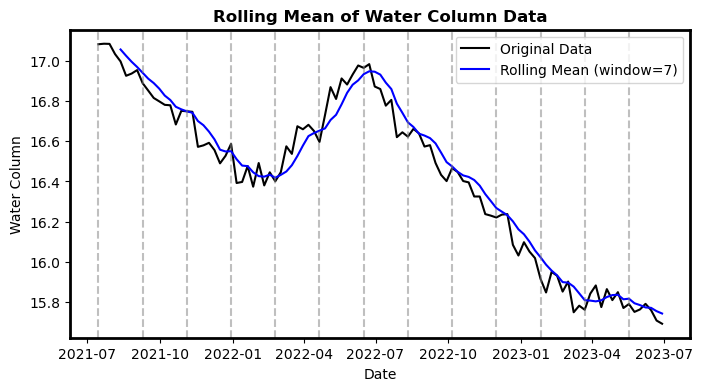

In [28]:
# # Define the rolling window size
# window_size = 5

# # Calculate the rolling mean
# rolling_mean = arima_data['Water Column'].rolling(window=window_size).mean()

# # Plot the original data and rolling mean
# plt.figure(figsize=(8, 4))
# plt.plot(arima_data['Water Column'], color='black', label='Original Data')
# plt.plot(rolling_mean, color='blue', label='Rolling Mean (window=7)')

# # Set labels and title
# plt.xlabel('Date')
# plt.ylabel('Water Column')
# plt.title('Rolling Mean of Water Column Data', fontweight='bold') # Make title bold

# # # Add vertical lines for each week
# current_date = arima_data.index.min()
# end_date = arima_data.index.max()
# while current_date <= end_date:
#     plt.axvline(current_date, color='grey', linestyle='--', alpha=0.5)
#     current_date += pd.DateOffset(weeks=8)
    

# # Add bold border around the plot
# ax = plt.gca()
# for spine in ax.spines.values():
#     spine.set_linewidth(2)

# # Add legend
# plt.legend()

# plt.show()


### From the plot, we can observe the following:

    - The rolling mean smoothens the data and removes short-term fluctuations, making it easier to identify long-term trends.
    
    - The rolling mean still exhibits the seasonal pattern seen in the original data, with recurring peaks and troughs.

### - Using `Dicky - Fuller` Test to check stationarity

In [20]:
from statsmodels.tsa.stattools import adfuller

# Define the function to run the Dickey-Fuller test
def dickey_fuller_test(series, diff_level):
    result = adfuller(series.diff(diff_level).dropna())
    print(f"Dickey-Fuller Test for differencing level {diff_level}:")
    print(f"Test Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    print()

# Run the Dickey-Fuller test for differencing levels 1, 2, and 3
for diff_level in range(1, 4):
    dickey_fuller_test(arima_data['Water Column'], diff_level)


Dickey-Fuller Test for differencing level 1:
Test Statistic: -13.160683554397531
p-value: 1.3092927900934102e-24
Critical Values: {'1%': -3.4968181663902103, '5%': -2.8906107514600103, '10%': -2.5822770483285953}

Dickey-Fuller Test for differencing level 2:
Test Statistic: -2.2552189413915036
p-value: 0.18681754488259839
Critical Values: {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}

Dickey-Fuller Test for differencing level 3:
Test Statistic: -2.020347174538389
p-value: 0.27772344420235334
Critical Values: {'1%': -3.5078527246648834, '5%': -2.895382030636155, '10%': -2.584823877658872}



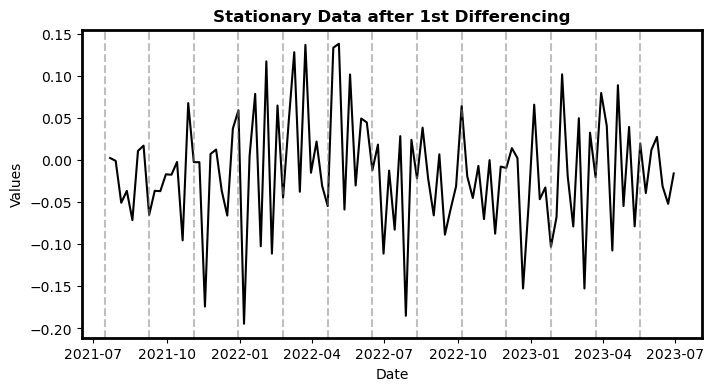

In [19]:
# Difference the original data with the order that made it stationary
stationary_data = arima_data['Water Column'].diff(1).dropna()

# Plot the differenced data
plt.figure(figsize=(8, 4))
plt.plot(stationary_data, color='black')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Stationary Data after 1st Differencing', fontweight='bold') # Make title bold

# # Add vertical lines for each week
current_date = arima_data.index.min()
end_date = arima_data.index.max()
while current_date <= end_date:
    plt.axvline(current_date, color='grey', linestyle='--', alpha=0.5)
    current_date += pd.DateOffset(weeks=8)

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
plt.savefig("differenced_WL.png", dpi=300)

plt.show()


### Result


    - Based on the results, it appears that the data becomes stationary after differencing it once (Level 1). 
    
    - Therefore, we reject the null hypothesis that the time series has a unit root (i.e., it is non-stationary) and conclude that the time series is stationary at the 1% level.
    
    
## Summary on `Stationarity`
---

    - In the process of assessing the stationarity of our time series data, we implemented two methodologies: differencing and rolling statistics. These techniques are commonly utilized to eliminate trends or seasonality from the data, which are typical sources of non-stationarity.

    - For differencing, we performed a first-order differencing, where each observation is subtracted from the preceding observation. We assessed the stationarity of the differenced series using the Augmented Dickey-Fuller (ADF) test, a statistical test for unit roots in a time series sample. The ADF test yielded a test statistic of -6.889, and the corresponding p-value was 1.37e-09. The critical values for the 1%, 5%, and 10% significance levels were -3.5019, -2.8928, and -2.5835, respectively. Since the absolute value of the test statistic was greater than the absolute critical values and the p-value was below the significance level, we rejected the null hypothesis of the presence of a unit root, indicating that the differenced series is stationary.

    - In addition, we explored rolling statistics by calculating the rolling mean over different window sizes. Specifically, we examined window sizes of 5 and 7. With a window size of 5, the rolling mean curve appeared relatively smooth, and further increasing the window size to 7 resulted in an even smoother curve. These smoothed curves allow for the observation of long-term trends in the data and facilitate the identification of patterns that might be obscured by noise in the original data. By reducing fluctuations and revealing underlying patterns, rolling statistics can be particularly useful for the analysis and modeling of time series data.

    - In conclusion, both the differencing and rolling statistics techniques were valuable for assessing and addressing non-stationarity in our time series data. The differenced series, as confirmed by the ADF test, was found to be stationary, making it suitable for further analysis and modeling. Meanwhile, rolling statistics provided an effective approach for visualizing trends and patterns in the data, aiding in the interpretation and understanding of the time series.

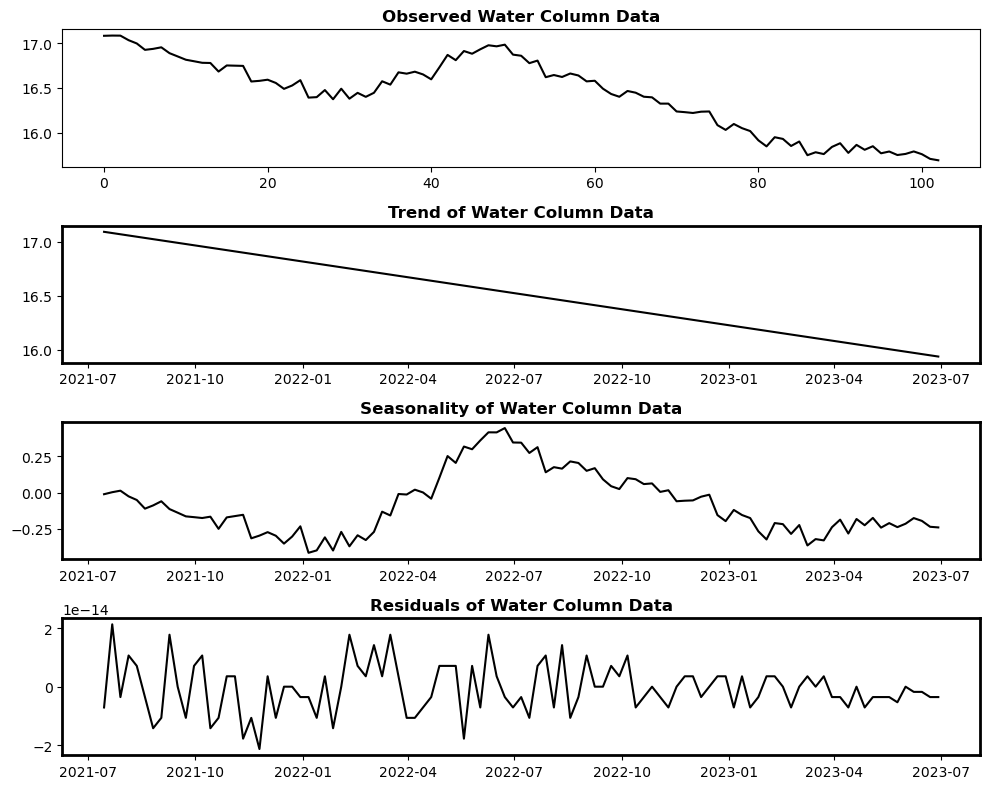

In [31]:
from statsmodels.tsa.seasonal import STL
# Make sure arima_data is a pandas Series or 1D array
# For instance, if arima_data is a DataFrame with a column 'Water Column', select only that column
series = arima_data['Water Column']

# Perform STL decomposition
stl = STL(series, seasonal=7)
result = stl.fit()


# Plot the trend, seasonality, and residuals
plt.figure(figsize=(10, 8))

# Observed Series
plt.subplot(4, 1, 1)
plt.plot(series.values, color='black')
plt.title('Observed Water Column Data', fontweight='bold') # Make title bold

# Trend
plt.subplot(4, 1, 2)
plt.plot(result.trend, color='black')
plt.title('Trend of Water Column Data', fontweight='bold') # Make title bold

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Seasonality
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, color='black')
plt.title('Seasonality of Water Column Data', fontweight='bold') # Make title bold

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Residuals
plt.subplot(4, 1, 4)
plt.plot(result.resid, color='black')
plt.title('Residuals of Water Column Data', fontweight='bold') # Make title bold

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.tight_layout()
plt.show()

### Ljung-Box test

    - It is a statistical test for autocorrelation in the residuals. Stable residuals should not show any significant autocorrelation.
    - A low p-value (typically ≤ 0.05) indicates that the residuals show significant autocorrelation and may not be stable.

In [40]:
# Extract the residuals from the decomposition
residuals = result.resid.dropna()

# Perform the Ljung-Box test on the residuals
p_values = acorr_ljungbox(residuals, lags=10)

# Print the p-values for the first 10 lags
print("Ljung-Box Test P-values:", p_values)

Ljung-Box Test P-values:      lb_stat  lb_pvalue
1   0.010075   0.920047
2   0.010162   0.994932
3   0.010715   0.999706
4   0.049544   0.999698
5   0.306201   0.997525
6   0.321200   0.999388
7   1.004115   0.994762
8   1.622596   0.990480
9   3.604665   0.935457
10  4.813681   0.903272


## Summary of Decomposition 

In our study, we employed two key methods for analyzing the time series data of the 'Water Column': `the Ljung-Box test for autocorrelation` and `the Seasonal Decomposition of Time Series (STL)`. These techniques were essential for decomposing the data and identifying significant underlying patterns.

---

    - The Ljung-Box test, a widely-used statistical test, was employed to examine autocorrelation in the residuals of the time series model. The presence of autocorrelation would imply that the model has not adequately captured the time-dependent structure in the data. Fortunately, our application of the Ljung-Box test found no significant autocorrelation in the residuals, suggesting that our time series model successfully captured most of the inherent patterns.

    - We further investigated the 'Water Column' time series using the Seasonal Decomposition of Time Series (STL) method. This approach offers several advantages over traditional seasonal decomposition methods, such as its ability to handle both additive and multiplicative seasonality. Moreover, it provides flexibility in modeling various trend types, including linear and exponential, and irregular components. The STL decomposition revealed a discernible downward trend in our data. However, no apparent seasonality was identified. This lack of clear seasonality might be due to subtle seasonality patterns being overshadowed by other data components or that the seasonal variation is not strong enough to be evident.
---

    In summary, the findings from the Ljung-Box test and the STL decomposition provided essential insights into the characteristics of the 'Water Column' time series data. The identified downward trend and the absence of significant autocorrelation in the residuals have important implications for the modeling and forecasting of this time series. These insights will guide the selection of appropriate time series models and the formulation of accurate predictions, considering the identified trend, seasonality, and residual components.

### ACF and PACF Plot for (MA and AR)

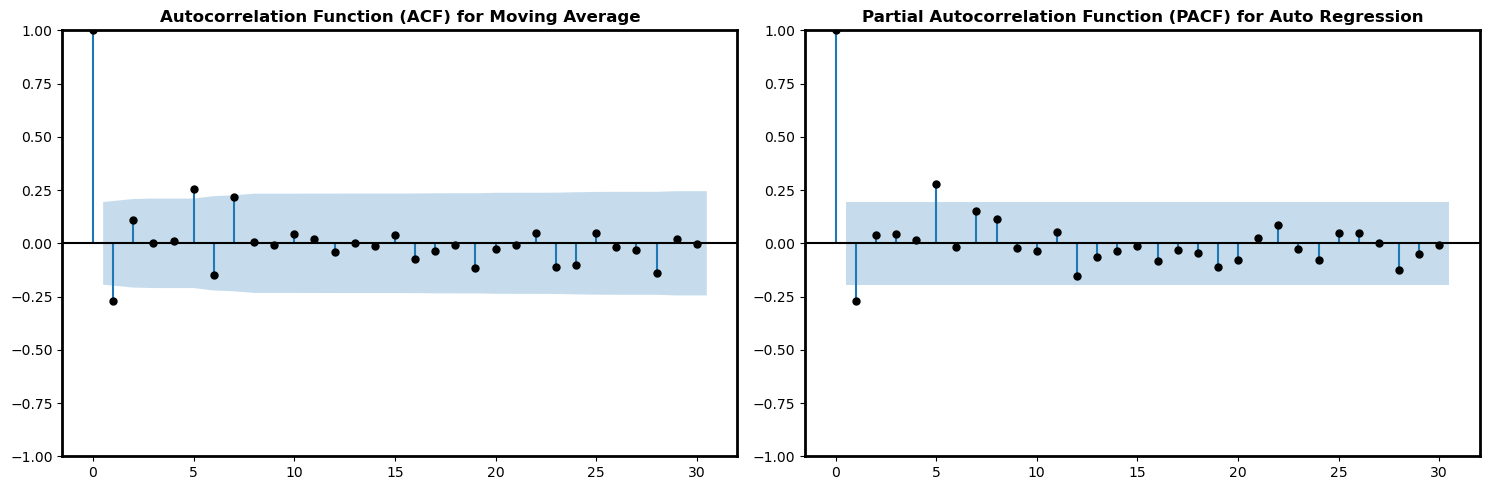

In [82]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the ACF on the first subplot
plot_acf(stationary_data.values, lags=30, ax=axes[0], color = 'black')
axes[0].set_title('Autocorrelation Function (ACF) for Moving Average', fontweight='bold')

# Add bold border around the plot
for spine in axes[0].spines.values():
    spine.set_linewidth(2)

# Plot the PACF on the second subplot
plot_pacf(stationary_data.values, lags=30, ax=axes[1], color ='black')
axes[1].set_title('Partial Autocorrelation Function (PACF) for Auto Regression', fontweight='bold')

# Add bold border around the plot
for spine in axes[1].spines.values():
    spine.set_linewidth(2)

# # Show the plots
plt.tight_layout()
plt.savefig("ACF_PACF.png", dpi=300)

plt.show()


## Summary for ARIMA Model

---
    - Differencing: One of the essential steps in time series analysis is to ensure that the data is stationary. The Dickey-Fuller test indicated that a differencing level of 1 effectively removed non-stationarity in the data, making it suitable for ARIMA modeling.

    - ACF and PACF plots: These plots are invaluable for identifying the appropriate order of the AR and MA components of the ARIMA model. The ACF plot showed significant spikes from lag 1 to lag 7, with the most prominent spike occurring at lag 1, which gradually diminished up to lag 7. Beyond lag 7, the ACF plot falls below the confidence interval, indicating no significant autocorrelation at higher lags. This suggests that an MA(7) term could be appropriate for the ARIMA model. Meanwhile, the PACF plot revealed a significant spike at lag 1, indicating an autoregressive process of order 1. Consequently, an AR(1) term should be incorporated into the ARIMA model.

---

### Mathematical Representations
---
1. **AR (Autoregressive) Component**: The AR component is a linear combination of the past values of the time series. Mathematically, the AR component of order $ p $ is defined as:

$  AR(p): Y_t = \alpha_1 Y_{t-1} + \alpha_2 Y_{t-2} + \ldots + \alpha_p Y_{t-p} + \epsilon_t $

where:
- $ Y_t $ is the value of the time series at time $ t $.
- $\alpha_1, \alpha_2, \ldots, \alpha_p $ are the AR coefficients.
- $\epsilon_t $ is the error term at time $t$.

2. **MA (Moving Average) Component**: The MA component is a linear combination of the past error terms. Mathematically, the MA component of order $q$ is defined as:

$ MA(q): Y_t = \beta_1 \epsilon_{t-1} + \beta_2 \epsilon_{t-2} + \ldots + \beta_q \epsilon_{t-q} + \epsilon_t  $

where:
- $ Y_t $ is the value of the time series at time $ t $.
- $ \beta_1, \beta_2, \ldots, \beta_q $ are the MA coefficients.
- $ \epsilon_t $ is the error term at time $ t $.

3. **I (Integration) Component**: The I component represents the order of differencing applied to the time series to make it stationary. Mathematically, the first order differencing is defined as:

$ I(1): \Delta Y_t = Y_t - Y_{t-1}  $

where:
- $ Y_t $ is the value of the time series at time $ t $.
- $ \Delta Y_t $ is the difference between $ Y_t $ and $ Y_{t-1} $.

Higher orders of differencing can be applied by taking the difference of the differences.

4. **ARIMA Model**: The combined ARIMA model of order $ (p, d, q) $ is defined as:

$ ARIMA(p, d, q): \Delta^d Y_t = \alpha_1 \Delta^d Y_{t-1} + \ldots + \alpha_p \Delta^d Y_{t-p} + \beta_1 \epsilon_{t-1} + \ldots + \beta_q \epsilon_{t-q} + \epsilon_t  $

where:
- $ Y_t $ is the value of the time series at time $ t $.
- $ \Delta^d Y_t $ is the $ d $th order difference of $ Y_t $.
- $ \alpha_1, \ldots, \alpha_p $ are the AR coefficients.
- $ \beta_1, \ldots, \beta_q $ are the MA coefficients.
- $ \epsilon_t $ is the error term at time $ t $.

    
### Based on these key metrics, we can conclude that an ARIMA(1, 1, 7) model may be appropriate for this data. 

    Additionally,the presence of a downward trend and the successful capture of this trend with a seasonal value of 7 suggest that a seasonal ARIMA (SARIMA) model may also be considered.

---

    Based on this evidence, we have chosen to proceed with an ARIMA(1,1,7) model. This model includes an AR term of order 1, an MA term of order 7, and a differencing level of 1. We believe that this model will serve as an effective baseline for capturing the inherent patterns in the 'Water Column' time series. In the following analysis, we will fit and evaluate this model on the training data, validate its performance on a holdout dataset, and assess its accuracy using appropriate metrics such as RMSE and MAPE.

## ARIMA Model

In [21]:
def nash_sutcliffe_efficiency(observed, predicted):
    """
    Compute the Nash-Sutcliffe Efficiency.

    Parameters:
    - observed : list or array-like
        List or array of observed values
    - predicted : list or array-like
        List or array of predicted values

    Returns:
    - nse : float
        Nash-Sutcliffe Efficiency
    """
    observed_mean = np.mean(observed)
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - observed_mean) ** 2)
    nse = 1 - (numerator / denominator)
    return nse

In [22]:
import numpy as np

def mean_absolute_percentage_error(observed, predicted):
    """
    Compute the Mean Absolute Percentage Error.

    Parameters:
    - observed : list or array-like
        List or array of observed values
    - predicted : list or array-like
        List or array of predicted values

    Returns:
    - mape : float
        Mean Absolute Percentage Error
    """
    # Calculate the absolute percentage error for each data point
    absolute_percentage_error = np.abs((observed - predicted) / observed)

    # Calculate the mean of the absolute percentage errors
    mape = 100 * np.mean(absolute_percentage_error)

    return mape

In [23]:
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(arima_data) * 0.85)
train, test = arima_data['Water Column'][:train_size], arima_data['Water Column'][train_size:]

In [24]:
import time
# Fit an ARIMA model
# Fit an ARIMA model on the training data
#Best so far - (1,1,5)
## (1,1,7) didnt perform the best
# Start time capture
start_time = time.time()

model = ARIMA(train, order=(5,1,0))
fit_model = model.fit()

# Print the model summary
print(fit_model.summary())

# End time capture
end_time = time.time()
# Calculate elapsed time 
elapsed_time = end_time - start_time
print(elapsed_time)

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           Water Column   No. Observations:                   87
Model:                 ARIMA(1, 1, 5)   Log Likelihood                 110.770
Date:                Fri, 01 Sep 2023   AIC                           -207.540
Time:                        02:08:05   BIC                           -190.359
Sample:                    07-15-2021   HQIC                          -200.625
                         - 03-09-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4786      0.331     -1.446      0.148      -1.127       0.170
ma.L1          0.2637      0.303      0.869      0.385      -0.331       0.858
ma.L2         -0.0467      0.124     -0.377      0.7

In [25]:
# Make predictions for the training set
train_predictions = fit_model.predict(start=1, end=len(train), dynamic=False)

# Make predictions for the test set
test_predictions = fit_model.forecast(steps=len(test))

In [27]:
# Calculate and print metrics for the training set
print('Training Metrics:')
print(f'MAPE: {mean_absolute_percentage_error(train, train_predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(train, train_predictions, squared=False))}')
print(f'NSE: {nash_sutcliffe_efficiency(train, train_predictions)}')
print()

# Calculate and print metrics for the test set
print('Testing Metrics:')
print(f'MAPE: {mean_absolute_percentage_error(test, test_predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(test, test_predictions, squared=False))}')
print(f'NSE: {nash_sutcliffe_efficiency(test, test_predictions)}')
print()

Training Metrics:
MAPE: 0.312466009826243
RMSE: 0.162474784572677
NSE: 0.9581961459295015

Testing Metrics:
MAPE: 0.27157577789753307
RMSE: 0.22887726992580687
NSE: 0.06433638977674927



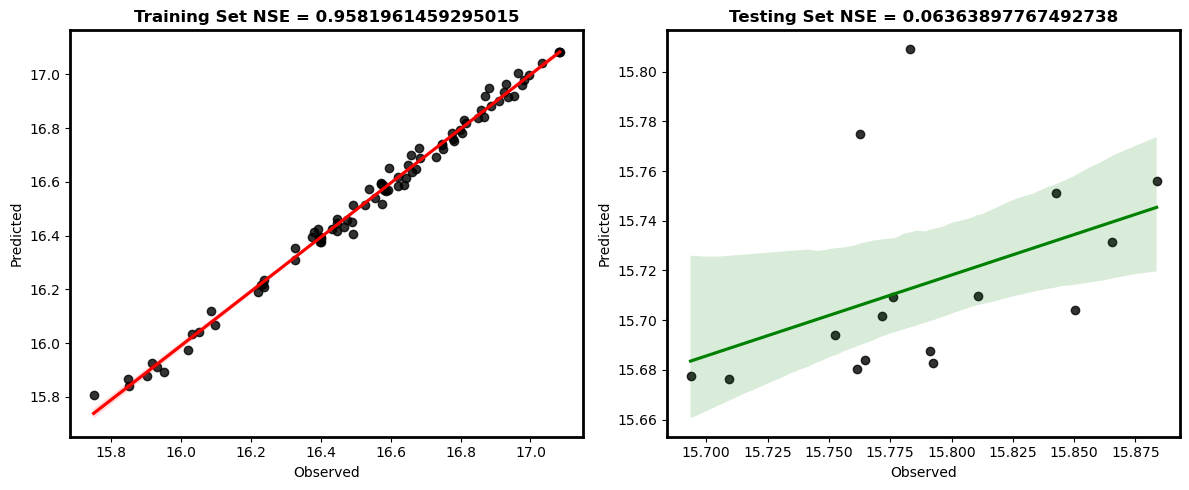

In [138]:
# Create a figure
plt.figure(figsize=(12, 5))

# Plot the training predictions
plt.subplot(1, 2, 1)
sns.regplot(x=train, y=train_predictions, color='black', line_kws={'color': 'red'})
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Training Set NSE = 0.9581961459295015', fontweight='bold') # Make title bold

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)


# Plot the testing predictions
plt.subplot(1, 2, 2)
sns.regplot(x=test, y=test_predictions, color='black', line_kws={'color': 'green'})
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Testing Set NSE = 0.06363897767492738', fontweight='bold') # Make title bold

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)


# Show the plots
plt.tight_layout()
plt.savefig("01_arima_fit_diagram.png", dpi=300)
plt.show()

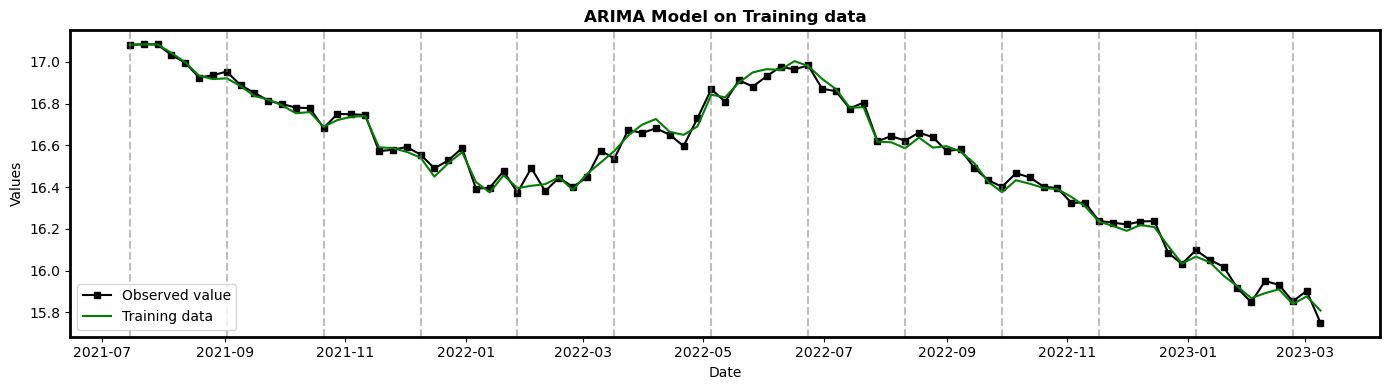

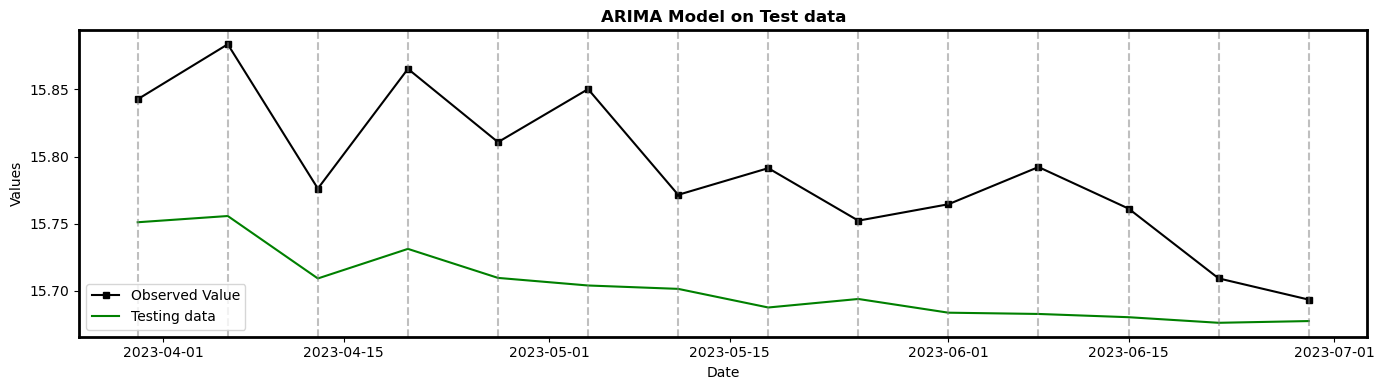

In [143]:
#Create a figure
plt.figure(figsize=(14, 4))

# Plot the actual observed values
plt.plot(arima_data.index[:train_size], arima_data['Water Column'][:train_size], label='Observed value', color='black', marker='s', markersize =4)
# Plot the training predictions
plt.plot(train.index, train_predictions, label='Training data', color='green', linestyle='solid')

# Add labels and a legend
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('ARIMA Model on Training data', fontweight='bold') # Make title bold
plt.legend(loc = 'lower left')


# # Add vertical lines for each week
current_date = arima_data.index[:train_size].min()
end_date = arima_data.index[:train_size].max()
while current_date <= end_date:
    plt.axvline(current_date, color='grey', linestyle='--', alpha=0.5)
    current_date += pd.DateOffset(weeks=7)

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Show the plot
plt.tight_layout()
plt.savefig("02_arima_forecast_diagram.png", dpi=300)
plt.show()


plt.figure(figsize=(14, 4))
# Plot the actual observed values
plt.plot(arima_data.index[train_size+2:], arima_data['Water Column'][train_size+2:], label='Observed Value', color='black', marker='s', markersize =4)
#Plot the testing predictions
plt.plot(arima_data.index[train_size+2:], test_predictions[2:], label='Testing data', color='green', linestyle='solid')

# Add labels and a legend
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('ARIMA Model on Test data', fontweight='bold') # Make title bold
plt.legend(loc = 'lower left')

# # Add vertical lines for each week
current_date = arima_data.index[train_size+2:].min()
end_date = arima_data.index[train_size+2:].max()
while current_date <= end_date:
    plt.axvline(current_date, color='grey', linestyle='--', alpha=0.5)
    current_date += pd.DateOffset(weeks=1)

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Show the plot
plt.tight_layout()
#plt.savefig("03_arima_forecast_diagram.png", dpi=300)
plt.show()

## Fine Tuninig Hyper Parameters

## Conclusion 

In [228]:
#arima_data.to_csv('LSTM.csv')